# Simple L-System for Space Engineers

Uses the PCGSEPy library included in this repository.

**NOTE**: Have the game *running*; leaving the game simply paused breaks the API (no calls are accepted). *Suggestion*: Use windowed mode, press `Start` after the scenario is loaded and return to this notebook.

Import base packages

In [1]:
import json

from pcgsepy.config import *
from pcgsepy.structure import block_definitions, Structure

Strings used as high-level structure:
- `cockpit`
- `engine`
- `corridor`
- `thruster`
- etc...

Strings used to define blocks:
- *See `block_definitions.json` for a full list*.

Strings used to define rotation commands:
- `rotXcwY`: Clockwise rotation from X to Y
- `rotXcwZ`: Clockwise rotation from X to Z
- `rotYcwX`: Clockwise rotation from Y to X 
- `rotYcwZ`: Clockwise rotation from Y to Z 
- `rotZcwX`: Clockwise rotation from Z to X 
- `rotZcwY`: Clockwise rotation from Z to Y 
- `rotXccwY`: Counter-clockwise rotation from X to Y 
- `rotXccwZ`: Counter-clockwise rotation from X to Z  
- `rotYccwX`: Counter-clockwise rotation from Y to X  
- `rotYccwZ`: Counter-clockwise rotation from Y to Z  
- `rotZccwX`: Counter-clockwise rotation from Z to X  
- `rotZccwY`: Counter-clockwise rotation from Z to Y   

Characters used as actions:
- `[` and `]`]: Push and pop current coordinate
- `+`: Move forward along `x`
- `-`: Move backward along `x`
- `!`: Move forward along `y`
- `?`: Move backward along `y`
- `>`: Move forward along `z`
- `<`: Move backward along `z`

## Parsing rules

Rules are written in the text files (defined in the configuration file) and are then read and validated by the `RuleMaker`. A rule set is then created as a `StochasticRules` object.

The `LParser` expands a given axiom using its rule set.

**NOTE**: Rules can have multiple characters in the *RHS*, which allows for more complex axioms. Rules are stochastic (i.e.: $LHS \rightarrow p(RHS | LHS)$); to make a rule deterministic simply use a single $LHS \rightarrow RHS$ with $p=1.$.

In [2]:
from pcgsepy.lsystem.parser import LParser
from pcgsepy.lsystem.rules import StochasticRules, RuleMaker

## Alphabets

We define the alphabets used in the L-System.

We first have the alphabet comprised of common atoms.

In [3]:
from pcgsepy.lsystem.actions import *
from pcgsepy.common.vecs import Vec, orientation_from_str

with open(COMMON_ATOMS, 'r') as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]['action'], common_alphabet[k]['args']
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {'action': action, 'args': args}

Then the alphabet with high-level atoms is loaded, providing also the dimension of each atom in a high-level structure.

In [4]:
with open(HL_ATOMS, 'r') as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]['dimensions']
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

And then the alphabet of low-level atoms is loaded.

In [5]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]
    
for k in block_definitions.keys():
    if k != "":  # TODO: This is a probable bug, reported to the SE API devs
        ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## Constraints

Constraints are `ConstraintHandler` objects with a constraint function defined in the `pcgsepy.lsystem.constraints_funcs` module. Each of these constraints must always return a `bool` (`True` if the constraint is satisfied, `False` otherwise).

Additional parameters for the constraints can be defined by adding the parameter to the `extra_args` dictionary of the `ConstraintHandler` object after initialization.

In [6]:
from pcgsepy.lsystem.constraints import *
from pcgsepy.lsystem.constraints_funcs import *

## Solver class

The `Solver` can both solve for a given axiom and fill a `Structure` with an axiom.

In [7]:
from pcgsepy.lsystem.solver import LSolver

## L-System

The `LSystem` populates different structures with L-system solutions at different iterations.

In [8]:
from pcgsepy.lsystem.lsystem import LSystem

In [9]:
# TODO: Read this from a file?

req_tiles = [
    'cockpit',
    'corridor',
    'thruster'
]

### HL SOLVER ###
Expansion n.1/4; current number of axioms: 1
Expansion n.2/4; current number of axioms: 1
--- EXPANDING AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>
--- EXPANSION CONSTRAINTS CHECK ---
Constraint no_intersections (HARD_CONSTRAINT) at DURING:	True
--- EXPANDING AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>
--- EXPANSION CONSTRAINTS CHECK ---
Constraint no_intersections (HARD_CONSTRAINT) at DURING:	True
Expansion n.3/4; current number of axioms: 1
--- EXPANDING AXIOM ---
 cockpit>>>>>corridor>>>>>?????RotZcwY[corridor>>>>>]!!!!!corridor>>>>>corridor>>>>>
--- EXPANSION CONSTRAINTS CHECK ---
Constraint no_intersections (HARD_CONSTRAINT) at DURING:	True
--- EXPANDING AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>corridor>>>>>?????RotZcwY[corridor>>>>>]!!!!!
--- EXPANSION CONSTRAINTS CHECK ---
Constraint no_intersections (HARD_CONSTRAINT) at DURING:	True
Expansion n.4/4; current number of axioms: 2
--- EXPANDING AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>c

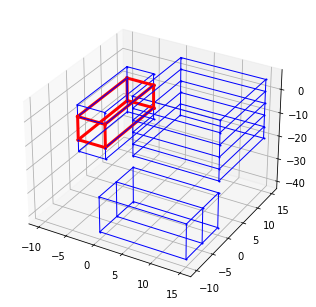

Constraint no_intersections (HARD_CONSTRAINT) at DURING:	False
--- EXPANDING AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>?????RotZcwY[corridor>>>>>thruster]!!!!!
--- EXPANSION CONSTRAINTS CHECK ---
Constraint no_intersections (HARD_CONSTRAINT) at DURING:	True
--- EXPANDING AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>?????RotZcwY[corridor>>>>>thruster]!!!!!corridor>>>>>?????RotZcwY[corridor>>>>>]!!!!!corridor>>>>>corridor>>>>>
--- EXPANSION CONSTRAINTS CHECK ---


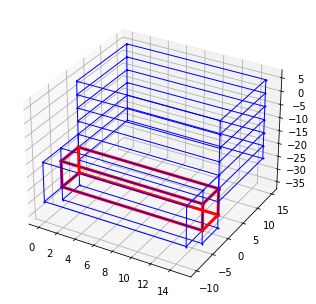

Constraint no_intersections (HARD_CONSTRAINT) at DURING:	False
--- EXPANDING AXIOM ---
 cockpit>>>>>corridor>>>>>-----RotZcwX[corridor>>>>>]+++++?????RotZcwY[corridor>>>>>thruster]!!!!!corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>
--- EXPANSION CONSTRAINTS CHECK ---
Constraint no_intersections (HARD_CONSTRAINT) at DURING:	True
--- AXIOM ---
 cockpit>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>?????RotZcwY[corridor>>>>>thruster]!!!!!
--- FINAL CONSTRAINTS CHECK---
Constraint required_components (HARD_CONSTRAINT) at END:	True
--- AXIOM ---
 cockpit>>>>>corridor>>>>>-----RotZcwX[corridor>>>>>]+++++?????RotZcwY[corridor>>>>>thruster]!!!!!corridor>>>>>corridor>>>>>corridor>>>>>corridor>>>>>
--- FINAL CONSTRAINTS CHECK---
Constraint required_components (HARD_CONSTRAINT) at END:	True

### LL SOLVER ###
Expansion n.1/1; current number of axioms: 1


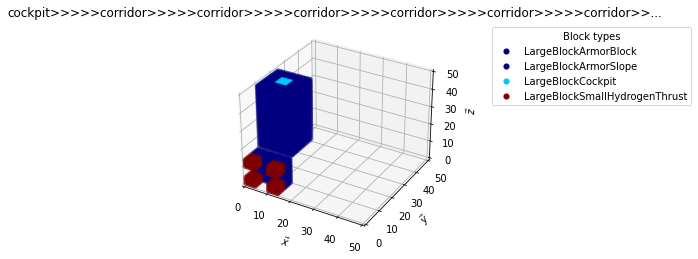

In [10]:
lsystem = LSystem(hl_rules="hlrules",
                  ll_rules="llrules", alphabet=dict(hl_alphabet, **ll_alphabet))

rcc = ConstraintHandler(name="required_components",
                        level=ConstraintLevel.HARD_CONSTRAINT,
                        when=ConstraintTime.END,
                        f=components_constraint)
rcc.extra_args['req_tiles'] = req_tiles

nic = ConstraintHandler(name="no_intersections",
                        level=ConstraintLevel.HARD_CONSTRAINT,
                        when=ConstraintTime.DURING,
                        f=intersection_constraint)
nic.extra_args['tiles_dimensions'] = tiles_dimensions

lsystem.add_hl_constraint(c=rcc)
lsystem.add_hl_constraint(c=nic)

structure = lsystem.apply_rules(
    starting_axiom="begin",
    iterations=4,
    make_graph=True,
)

# Game interaction

Place structure in-game by updating its position and rotation according to the player.

In [11]:
do_place_blocks = False

In [12]:
from pcgsepy.common.api_call import GameMode, get_base_values, toggle_gamemode
from pcgsepy.structure import place_blocks

if do_place_blocks:
    base_position, orientation_forward, orientation_up = get_base_values()
    structure.update(
        origin=base_position,
        orientation_forward=orientation_forward,
        orientation_up=orientation_up,
    )
    toggle_gamemode(GameMode.PLACING)
    place_blocks(structure.get_all_blocks(), False)
    toggle_gamemode(GameMode.EVALUATING)